In [10]:
import torch.optim as optim
from torch.utils.data import DataLoader

from score_models.models.mlp import MLPScoreModel
from score_models.trainer import trainer
from score_models.train_steps import TrainStepDenoisingScoreMatching
from score_models.utils.data import guassian_mixture
from score_models.utils.noise import get_sigmas

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
dataset = guassian_mixture(N=10_000)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [12]:
input_size = 2
hidden_size = 32
L = 10
lr = 5e-4

sigma_min = 1.0
sigma_max = 20.0

device = "cuda"

# define score model and optimizer
score_model = MLPScoreModel(input_size=input_size, hidden_size=hidden_size, L=L).to(device)
optimizer = optim.Adam(score_model.parameters(), lr=lr)

# define train step (i.e., criterion)
sigmas = get_sigmas(L=L, sigma_min=sigma_min, sigma_max=sigma_max)
train_step = TrainStepDenoisingScoreMatching(score_model=score_model, sigmas=sigmas)


In [13]:
score_model = trainer(
    train_step=train_step,
    model=score_model,
    train_loader=dataloader,
    optimizer=optimizer,
    device=device,
    num_steps=10_000,
    log_every=1000,
)

  0%|          | 11/10000 [00:00<03:16, 50.89it/s]

Step 0, Loss: 23.1392


 10%|█         | 1012/10000 [00:14<02:08, 70.21it/s]

Step 1000, Loss: 0.3287


 20%|██        | 2009/10000 [00:29<01:54, 69.52it/s]

Step 2000, Loss: 0.2728


 30%|███       | 3012/10000 [00:44<01:40, 69.40it/s]

Step 3000, Loss: 0.2646


 40%|████      | 4010/10000 [00:58<01:25, 70.46it/s]

Step 4000, Loss: 0.2862


 50%|█████     | 5015/10000 [01:13<01:11, 69.99it/s]

Step 5000, Loss: 0.2550


 60%|██████    | 6010/10000 [01:27<00:57, 69.53it/s]

Step 6000, Loss: 0.2737


 70%|███████   | 7009/10000 [01:42<00:42, 70.72it/s]

Step 7000, Loss: 0.2605


 80%|████████  | 8009/10000 [01:58<00:29, 66.63it/s]

Step 8000, Loss: 0.2509


 90%|█████████ | 9007/10000 [02:13<00:14, 66.83it/s]

Step 9000, Loss: 0.2598


100%|██████████| 10000/10000 [02:29<00:00, 66.98it/s]


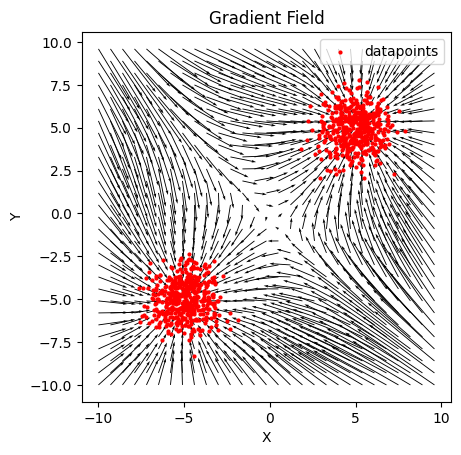

In [14]:
from score_models.utils.visualisations import plot_gradient_field
plot_gradient_field(score_model=score_model, i=L-1, datapoints=dataset[:1000])

In [18]:
import numpy as np
from tqdm import tqdm
from score_models.sampling import annealed_langevin_dynamics

samples = annealed_langevin_dynamics(
    score_model=score_model, input_size=(500, 2), sigmas=sigmas
).cpu().numpy()

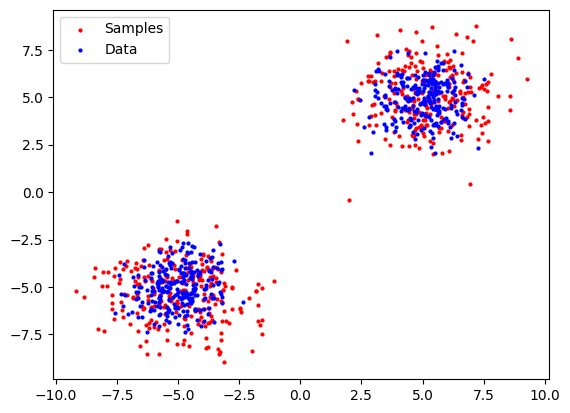

In [19]:
import matplotlib.pyplot as plt

ax = plt.gca()
ax.scatter(
    samples[:, 0], samples[:, 1], color='red', s=4, label='Samples'
)
ax.scatter(
    dataset[:500][:, 0], dataset[:500][:, 1], color='blue', s=4, label='Data'
)
plt.legend();